# Unsupervised Learning - Capstone Project

In [83]:
# Import dependencies

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Exploring the Data

#### Load and check view sample of the data

In [84]:
# Load data
us_arrests_df = pd.read_csv("UsArrests.csv", index_col="City")

print("Data:")
print(us_arrests_df.sample(5), end='\n\n')

Data:
              Murder  Assault  UrbanPop  Rape
City                                         
Tennessee      13.20      188        59 26.90
South Dakota    3.80       86        45 12.80
Washington      4.00      145        73 26.20
Vermont         2.20       48        32 11.20
Nebraska        4.30      102        62 16.50



In [85]:
print('Number of cases: {} Number of features: {}'.format(us_arrests_df.shape[0], us_arrests_df.shape[1]))

Number of cases: 50 Number of features: 4


#### View selected statistics of the data:

In [86]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = us_arrests_df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows

display(selected_stats)

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


####  Check for any missing data

In [87]:
# Count missing values
missing = us_arrests_df.isnull().sum()
missing.drop(columns=["City"], inplace=True) # No need to display City
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


### View the data types of the features

In [88]:
# Examine types
us_arrests_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


## 2. Cleaning the Data

Looking at the state of the data from the previous section, there is no missing data, columns needed for analysis are numeric and columns are helpfully named. Therefore, no further action is taken to clean the data

## 3. Data Visualization

#### Using Pair Plots to get a general sense of the data

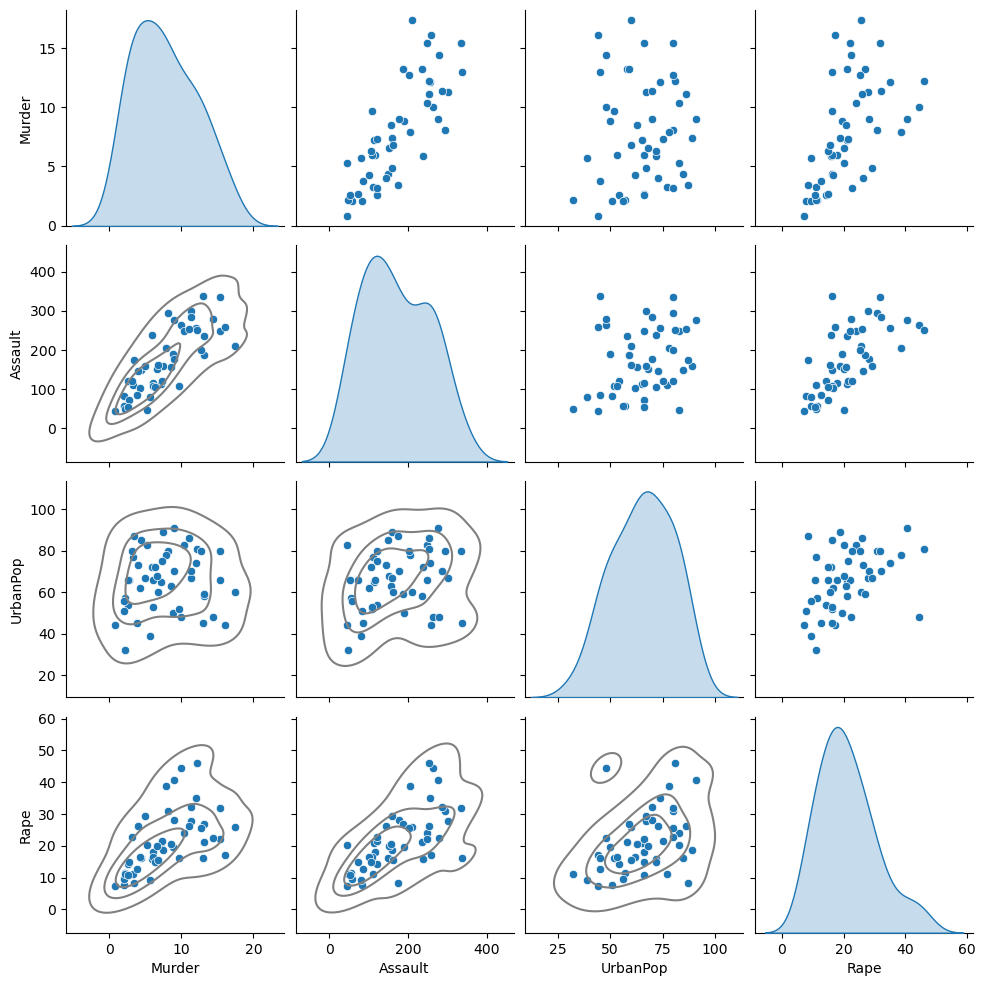

In [89]:
g = sns.pairplot(us_arrests_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color="grey")

plt.show()

####  Build summary using selective statistics, including stats on data missing

In [90]:
# Create summary table
summary = pd.concat([relevant_missing, selected_stats], axis=1)
summary.rename(columns={0:"missing"}, inplace=True)

display(summary)

,missing,mean,std,min,max
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


From the summary statistics, it shows that Assault has mean value higher than the other values. It also has the higher maximum value.

## 4. Correlation Analysis

To compute the correlations between the different function, I aim to use the built-in function from Pandas, corr(), which uses the Pearson coefficient.

In [91]:
cities = us_arrests_df.index
corr_df = us_arrests_df.corr()
labels =corr_df.columns

print(corr_df)

          Murder  Assault  UrbanPop  Rape
Murder      1.00     0.80      0.07  0.56
Assault     0.80     1.00      0.26  0.67
UrbanPop    0.07     0.26      1.00  0.41
Rape        0.56     0.67      0.41  1.00


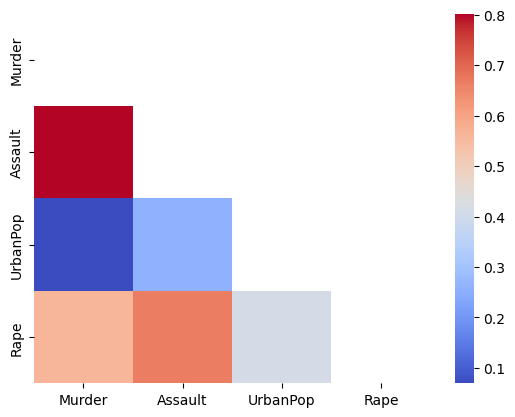

In [92]:
mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

plt.show()

The above plot graphs out the linear correlation between strongly correlated variables. Coloured as either dark red or dark blue.

* __Positively correlated__ variables are red: Increase in one corresponds to an increase in the other.
* __Negatively correlated__ variables are blue: a decrease in one means an increase in the other.

This graph shows that Murder has a very strong correlation with Assault and to a lesser Rape. One could logically attribute that murder would only follow after an assault. Whereas, it has a negative correlation to Urban Population (UrbanPop). It would imply that increase in population in urban areas would decrease assault and rape cases. Possibly due to more people serves as deterrent to crime.

Furthermore, Assault has a strong correlation with Rape. Which can be explained due to the severe nature of the crime.

## 5. Principal Component Analysis (PCA)

In [93]:
np.set_printoptions(precision=2)

X = us_arrests_df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [94]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [95]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [96]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


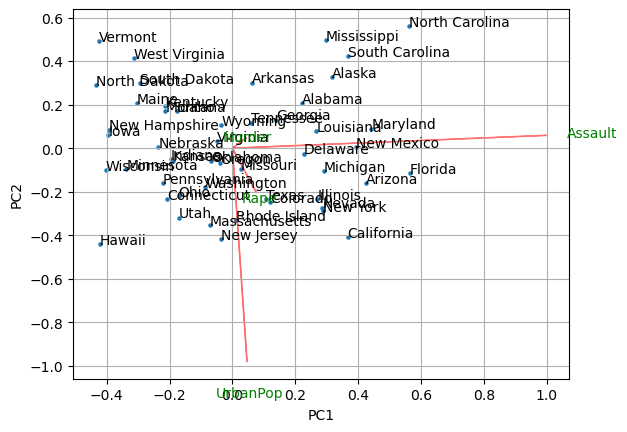

In [97]:
def biplot(score, coeff, labels=None, points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = points[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

biplot(X_trans[:,0:2], np.transpose(pca.components_[0:2, :]), list(labels), list(cities))
plt.show()

The above graph can be quantified as follows:

In [98]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


This shows that Assault is by far the highest importance to the first principal component. While Urban Population are the highest for the second principal component.

From our summary statistics earlier, Assault did show the highest mean (and max) which could "overwhelm" the others.

### 5.2. Standardise Data

We standardise the data so that some features do not overwhelm the others.

In [99]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


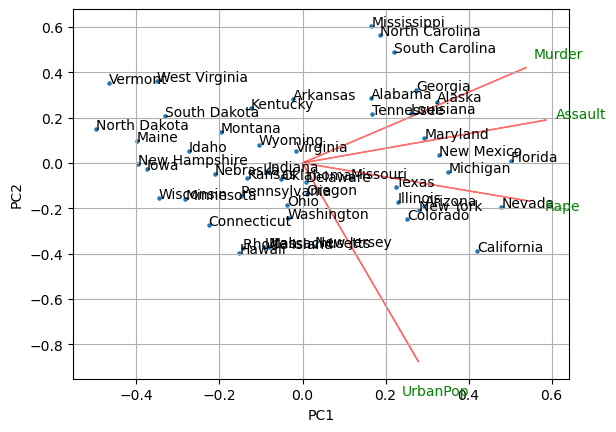

In [100]:
biplot(X_std_trans[:,0:2], np.transpose(std_pca.components_[0:2, :]), list(labels), list(cities))
plt.show()

From the above graph, more variables are being utilised from the standardised results as the large numbers are not dominating. Although, it is still difficult to see any clustering.

In [101]:
# Feature importance
pc1 = abs(std_pca.components_[0])
pc2 = abs(std_pca.components_[1])

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


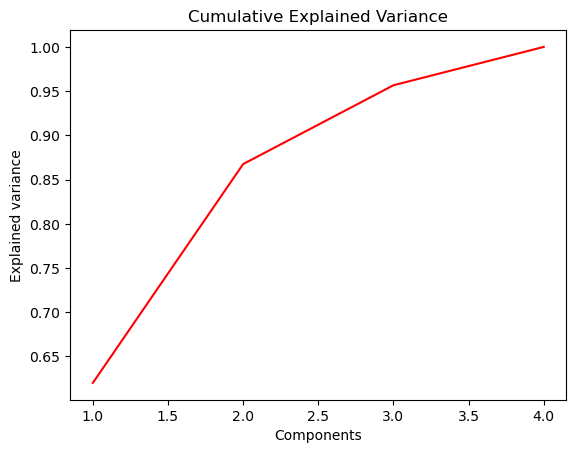

In [102]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1), np.cumsum(std_pca.explained_variance_ratio_), c='red')
plt.title("Cumulative Explained Variance")

plt.show()

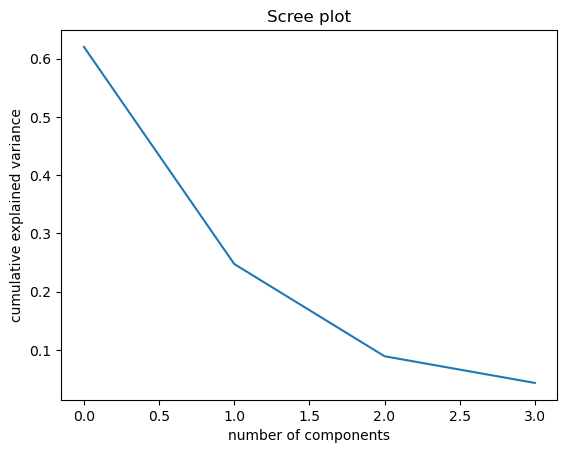

In [103]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 3 principal components together explain around 95% of the variance. We can therefore use them to perform cluster analysis. 

This is what we refer to as dimensionality reduction. We began with 4 variables and now we have 3 variables explaining most of the variability.

In [104]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = us_arrests_df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.986,1.133,-0.444
Alaska,1.950,1.073,2.040
Arizona,1.763,-0.746,0.055
Arkansas,-0.141,1.120,0.115
California,2.524,-1.543,0.599


## 6. Clustering

### 6.1 Hierarchical Clustering

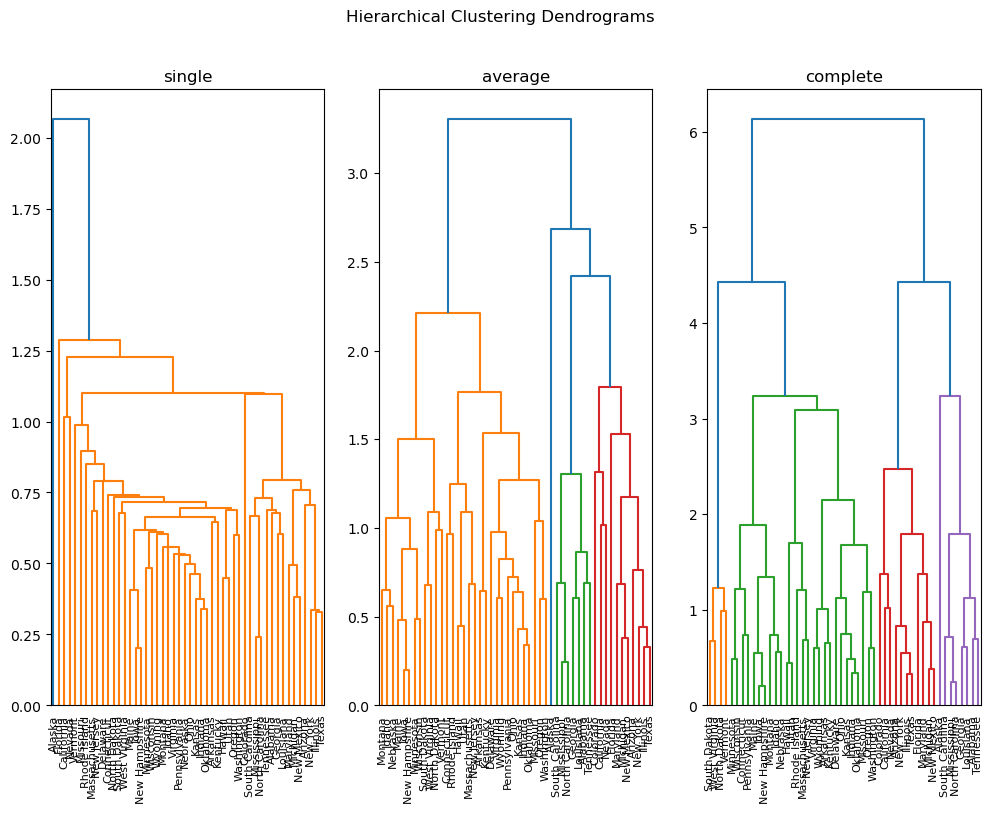

In [105]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, axs = plt.subplots(1, 3, figsize=(12, 8))
fig.suptitle('Hierarchical Clustering Dendrograms')

for index, method_type in enumerate(["single", "average", "complete"]):
    axs[index].set_title(method_type)
    dendrogram(linkage(pca_df, method=method_type), labels=pca_df.index, ax=axs[index])

plt.show()

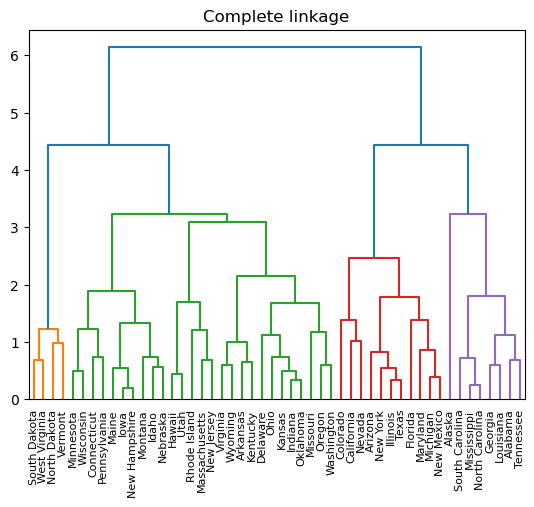

In [106]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method="complete"), labels=pca_df.index)
plt.show()

### 6.2. K-means Clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


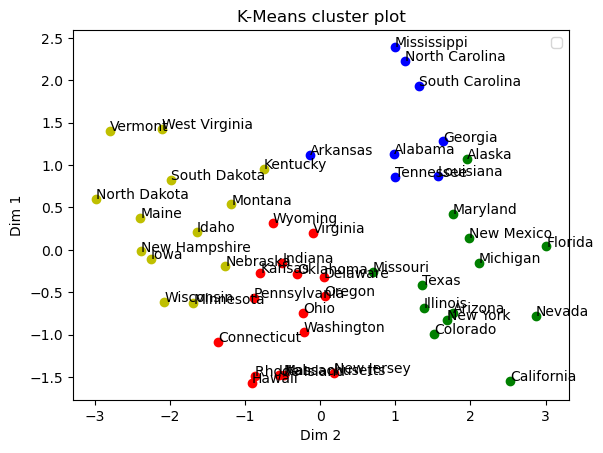

In [107]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

plt.show()

In [108]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]
group3_indices = np.argwhere(cluster_labels==3).transpose()[0]

group0 = np.array(cities)[group0_indices]
group1 = np.array(cities)[group1_indices]
group2 = np.array(cities)[group2_indices]
group3 = np.array(cities)[group3_indices]


print("Group 0: {}\n\n".format(group0))
print("Group 1: {}\n\n".format(group1))
print("Group 2: {}\n\n".format(group2))
print("Group 3: {}\n\n".format(group3))

Group 0: ['Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas' 'Massachusetts'
 'New Jersey' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
 'Utah' 'Virginia' 'Washington' 'Wyoming']


Group 1: ['Alabama' 'Arkansas' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina'
 'South Carolina' 'Tennessee']


Group 2: ['Alaska' 'Arizona' 'California' 'Colorado' 'Florida' 'Illinois'
 'Maryland' 'Michigan' 'Missouri' 'Nevada' 'New Mexico' 'New York' 'Texas']


Group 3: ['Idaho' 'Iowa' 'Kentucky' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
 'New Hampshire' 'North Dakota' 'South Dakota' 'Vermont' 'West Virginia'
 'Wisconsin']




## 7. Source Location

As per instructions, all source code can be found at the following location on GitHub:
[https://github.com/chrismouton/finalcapstone](https://github.com/chrismouton/finalcapstone)